# Efficient Fine-Tuning of Transformers: LoRA, QLoRA, and Unsloth

## Notebook Objective:

Provide a hands-on guide to the most efficient methods for fine-tuning large language models using:

* LoRA (Low-Rank Adaptation)
* QLoRA (Quantized LoRA for 13B+ models)
* Unsloth (Fast LoRA + quantization for LLaMA/Gemma)

By the end, students will:

* Understand each method’s purpose and trade-offs.
* Fine-tune LLMs on real-world datasets using each method.
* Compare results and decide which technique fits which scenario.

# Introduction to PEFT (Parameter-Efficient Fine-Tuning)

## Why Not Full Fine-Tuning?

- **High compute cost**: updating all model weights requires storing gradients for every parameter, which scales memory usage by ~2–3× the model size.  
- **Slow iteration**: large backprop passes on 100M+–parameter models take hours even on A100s.  
- **Deployment complexity**: shipping full fine-tuned weights means re-serving the entire model, complicating version control and increasing storage.
- **Memory-Intensive**: Full fine-tuning uses significant GPU VRAM, making it impossible on low-end or free-tier hardware.

Instead, we turn to **Parameter-Efficient Fine-Tuning (PEFT)**.

## What is PEFT?

PEFT methods **fine-tune only a small portion of the model’s parameters**, while keeping the rest frozen. This drastically reduces:

* Required memory
* Training time
* Overfitting risks (especially on small datasets)

Popular PEFT methods include:

* LoRA (Low-Rank Adaptation)
* QLoRA (Quantized LoRA)
* Adapters

# LoRA Fine-Tuning with Hugging Face

**LoRA (Low-Rank Adaptation)** is a parameter-efficient fine-tuning technique that:

* **Freezes the base model weights**.
* Injects **small trainable matrices (low-rank)** into key components like attention layers.
* Dramatically **reduces GPU memory and compute needs**, while maintaining performance.

LoRA is supported via 🤗 Hugging Face’s **PEFT** (Parameter-Efficient Fine-Tuning) library, which makes integration seamless.

<img src="./Lora.png" width="500" style="display: block; margin: auto;">

*Image Source: [Hu, Edward J., et al.](https://arxiv.org/abs/2106.09685)*

A basic LoRA wrapper


```python
class LoRALinear(nn.Module):
    def __init__(self, original_layer, r=8, alpha=16):
        super().__init__()
        self.original = original_layer
        self.r = r
        self.alpha = alpha
        self.lora_A = nn.Linear(original_layer.in_features, r, bias=False)
        self.lora_B = nn.Linear(r, original_layer.out_features, bias=False)
        self.scaling = alpha / r

        # Initialize LoRA weights
        nn.init.kaiming_uniform_(self.lora_A.weight, a=0.02)
        nn.init.zeros_(self.lora_B.weight)

        # Freeze original weights
        for param in self.original.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.original(x) + self.scaling * self.lora_B(self.lora_A(x))
```

### Load Base Model and Tokenizer

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "HuggingFaceTB/SmolLM2-135M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

model.enable_input_require_grads()


### Set chat template

In [ ]:
from trl import setup_chat_format

model, tokenizer = setup_chat_format(model, tokenizer)

### Define LoRA

Here, we defince the LoRA hyperparameters and wrap our model. Note that doing so we get only a fraction of training parameters

In [57]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # adjust if needed for this model
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 745,472 || all params: 1,000,631,424 || trainable%: 0.0745


/home/hussam/Documents/Hochschule/Generative_AI/.venv/lib/python3.13/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/hussam/Documents/Hochschule/Generative_AI/.venv/lib/python3.13/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


### Load The Dataset

In [58]:
from datasets import load_dataset

train_dataset = load_dataset("HuggingFaceTB/smoltalk", "smol-rewrite", split="train")
eval_dataset = load_dataset("HuggingFaceTB/smoltalk", "smol-rewrite", split="test")

### Define the SFT Trainer

In [ ]:
from trl import SFTTrainer, SFTConfig

# Training configuration
# Hyperparameters based on QLoRA paper recommendations
args = SFTConfig(
    # Output settings
    output_dir='SmolLM2-LoRA-rewrite',  # Directory to save model checkpoints
    # Training duration
    num_train_epochs=1,  # Number of training epochs
    # Batch size settings
    per_device_train_batch_size=2,  # Batch size per GPU
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch
    # Memory optimization
    gradient_checkpointing=True,  # Trade compute for memory savings
    # Optimizer settings
    optim="adamw_torch_fused",  # Use fused AdamW for efficiency
    learning_rate=2e-4,  # Learning rate (QLoRA paper)
    max_grad_norm=0.3,  # Gradient clipping threshold
    # Learning rate schedule
    warmup_ratio=0.03,  # Portion of steps for warmup
    lr_scheduler_type="constant",  # Keep learning rate constant after warmup
    # Logging and saving
    logging_steps=10,  # Log metrics every N steps
    save_strategy="epoch",  # Save checkpoint every epoch
    # Precision settings
    bf16=True,  # Use bfloat16 precision
    max_seq_length=1512,
    packing=True,  # Enable input packing for efficiency
    dataset_kwargs={
        "add_special_tokens": False,  # Special tokens handled by template
        "append_concat_token": False,  # No additional separator needed
    },
)

max_seq_length = 1512  # max sequence length for model and packing of the dataset

# Create SFTTrainer with LoRA configuration
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,  # LoRA configuration
    processing_class=tokenizer,

)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

# save model
trainer.save_model()

# Quantization: Making Big Models Small(ish)

## What is Quantization?

Quantization reduces the memory and compute cost of machine learning models by converting weights from high-precision (e.g., `float32`) to low-precision formats like `int8` or `int4`.

>Instead of storing each number with 32 bits of precision, we store it with 8 or even 4 bits, saving space and making operations faster.

In [43]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "HuggingFaceTB/SmolLM2-360M"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model_fp32 = AutoModelForCausalLM.from_pretrained(model_name)
model_fp32.eval();


To quantize our model, we will use the `bitsandbytes` library. Ensure it is installed in your environment before proceeding.

In [50]:
from transformers import BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(load_in_8bit=True)

model_int8 = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model_int8.eval()

inputs = tokenizer("Why is the ocean salty?", return_tensors="pt").to("cuda")
with torch.no_grad():
    outputs = model_int8.generate(**inputs, max_new_tokens=50)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Why is the ocean salty?

The ocean is salty because it contains dissolved minerals. The ocean is salty because it contains dissolved minerals. The ocean is salty because it contains dissolved minerals. The ocean is salty because it contains dissolved minerals. The ocean is salty because it contains dissolved


## Quantization Precision Levels

Quantizing a model to different levels of precision allows for a trade-off between model performance and resource usage. In the following cell, we compare the VRAM usage of various quantized versions of our model.

In [52]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import gc

model_name = "HuggingFaceTB/SmolLM2-360M"

def get_memory_usage():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.reset_peak_memory_stats()
    return torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated()

tokenizer = AutoTokenizer.from_pretrained(model_name)
results = {}

# --- FP32 ---
torch.cuda.empty_cache(); gc.collect()
print("🔹 Loading FP32 model...")
model_fp32 = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")
fp32_alloc, _ = get_memory_usage()
results["FP32"] = fp32_alloc
print(f"📊 FP32 - Allocated: {fp32_alloc / 1e6:.2f} MB")
del model_fp32; torch.cuda.empty_cache(); gc.collect()

# --- FP16 ---
print("\n🔹 Loading FP16 model...")
model_fp16 = AutoModelForCausalLM.from_pretrained(model_name).half().to("cuda")
fp16_alloc, _ = get_memory_usage()
results["FP16"] = fp16_alloc
print(f"📊 FP16 - Allocated: {fp16_alloc / 1e6:.2f} MB")
del model_fp16; torch.cuda.empty_cache(); gc.collect()

# --- INT8 ---
print("\n🔹 Loading INT8 quantized model...")
bnb_config_8bit = BitsAndBytesConfig(load_in_8bit=True)
model_int8 = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config_8bit,
    device_map="auto"
)
int8_alloc, _ = get_memory_usage()
results["INT8"] = int8_alloc
print(f"📊 INT8 - Allocated: {int8_alloc / 1e6:.2f} MB")
del model_int8; torch.cuda.empty_cache(); gc.collect()

# --- 4-bit NF4 ---
print("\n🔹 Loading 4-bit NF4 quantized model...")
bnb_config_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
model_4bit = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config_4bit,
    device_map="auto"
)
nf4_alloc, _ = get_memory_usage()
results["4-bit NF4"] = nf4_alloc
print(f"📊 4-bit NF4 - Allocated: {nf4_alloc / 1e6:.2f} MB")
del model_4bit; torch.cuda.empty_cache(); gc.collect();



🔹 Loading FP32 model...
📊 FP32 - Allocated: 1590.86 MB

🔹 Loading FP16 model...
📊 FP16 - Allocated: 872.21 MB

🔹 Loading INT8 quantized model...
📊 INT8 - Allocated: 548.29 MB

🔹 Loading 4-bit NF4 quantized model...
📊 4-bit NF4 - Allocated: 396.25 MB


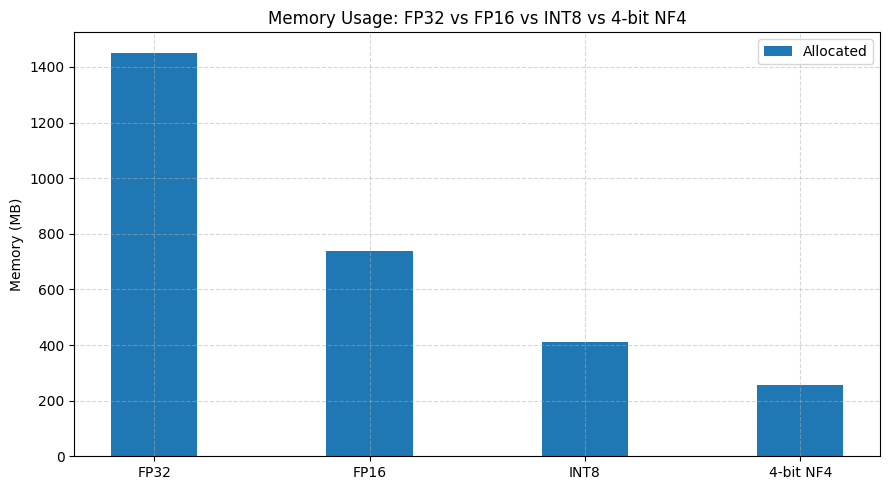

In [30]:
import matplotlib.pyplot as plt

labels = list(results.keys())
allocated = [v / 1e6 for v in results.values()]

x = range(len(labels))
plt.figure(figsize=(9, 5))
plt.bar(x, allocated, width=0.4, label='Allocated', align='center')
plt.xticks(x, labels)

plt.ylabel("Memory (MB)")
plt.title("Memory Usage: FP32 vs FP16 vs INT8 vs 4-bit NF4")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Summary

* Quantization **shrinks LLMs dramatically**, enabling inference (and training, via QLoRA) on GPUs with limited memory.
* Accuracy remains **comparable**, especially for tasks like text generation and classification.
* **8-bit quantization** is ideal for inference.
* **4-bit quantization + LoRA = QLoRA**, which enables full **training of 13B+ models** on a single A100!

# QLoRA: Quantized LoRA

**QLoRA** is a cutting-edge fine-tuning technique that enables training **very large models** (like LLaMA 13B/65B) on **consumer hardware** by combining:

* 4-bit quantization (NF4) to reduce memory footprint
* Double quantization to further compress weights
* LoRA adapters applied after quantization to avoid touching the full model weights

**QLoRA** works best with the following stack:

* `transformers`
* `bitsandbytes`
* `peft`

> 🧠 QLoRA = 4-bit Quantization + LoRA = Big Model Fine-Tuning on Small Hardware

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("HuggingFaceTB/smoltalk", "smol-rewrite", split="train")
eval_dataset = load_dataset("HuggingFaceTB/smoltalk", "smol-rewrite", split="test")

#### Setup BitsAndBytesConfig for 4-bit loading

In [2]:
from transformers import BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",             # Use NormalFloat4 quantization
    bnb_4bit_use_double_quant=True,        # Compress the quantization constants
    bnb_4bit_compute_dtype=torch.float16   # Efficient compute dtype
)


#### Load Quantized Model (e.g., gemma-3-1b)

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "HuggingFaceTB/SmolLM2-360M"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"  # Auto-distributes across available devices
)


set chat template

In [4]:
from trl import setup_chat_format

model, tokenizer = setup_chat_format(model, tokenizer)

#### Add LoRA Adapters via PEFT

In [5]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, TaskType

# Prepare model for QLoRA (adds input cast hooks etc.)
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 819,200 || all params: 362,640,320 || trainable%: 0.2259


In [6]:
from trl import SFTTrainer, SFTConfig

# Training configuration
# Hyperparameters based on QLoRA paper recommendations
args = SFTConfig(
    # Output settings
    output_dir='SmolLM2-LoRA-rewrite',  # Directory to save model checkpoints
    # Training duration
    num_train_epochs=1,  # Number of training epochs
    # Batch size settings
    per_device_train_batch_size=2,  # Batch size per GPU
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch
    # Memory optimization
    gradient_checkpointing=True,  # Trade compute for memory savings
    # Optimizer settings
    optim="adamw_torch_fused",  # Use fused AdamW for efficiency
    learning_rate=2e-4,  # Learning rate (QLoRA paper)
    max_grad_norm=0.3,  # Gradient clipping threshold
    # Learning rate schedule
    warmup_ratio=0.03,  # Portion of steps for warmup
    lr_scheduler_type="constant",  # Keep learning rate constant after warmup
    # Logging and saving
    logging_steps=10,  # Log metrics every N steps
    save_strategy="epoch",  # Save checkpoint every epoch
    # Precision settings
    bf16=True,  # Use bfloat16 precision
    max_seq_length=1512,
    packing=True,  # Enable input packing for efficiency
    dataset_kwargs={
        "add_special_tokens": False,  # Special tokens handled by template
        "append_concat_token": False,  # No additional separator needed
    },
)

# Create SFTTrainer with LoRA configuration
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,  # LoRA configuration
    processing_class=tokenizer,

)

Applying chat template to train dataset:   0%|          | 0/53342 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/53342 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/53342 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/2808 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/2808 [00:00<?, ? examples/s]

Packing eval dataset:   0%|          | 0/2808 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()
# save model
trainer.save_model()

In [ ]:
import torch
# 1️⃣ Memory usage
print("▶ Peak VRAM (MB):", torch.cuda.max_memory_allocated() / 1e6)

# 2️⃣ Generate a sample
prompt = "### Instruction:\nExplain transfer learning in simple terms.\n\n### Response:\n"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
out = model.generate(**inputs, max_new_tokens=60)
print(tokenizer.decode(out[0], skip_special_tokens=True))


# Fast Fine-Tuning with Unsloth

Why **Unsloth**?

Unsloth is a powerful toolkit that:

* **Speeds up LoRA fine-tuning** of language models (5–10x faster).
* **Uses 4-bit quantized weights** out-of-the-box with LoRA.
* Works on many open source models (**SmolLM2**, **LLaMA**, **Mistral**, etc.)
* Compatible with Hugging Face 🤗 `Trainer` or custom loops.

For our notebook, we’ll fine-tune the `unsloth/SmolLM2-135M-bnb-4bit` model on the `smoltalk` dataset.

> Make sure to install `unsloth` to your environment

## Load Model via Unsloth

In [ ]:
from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/smolllm2-135m-bnb-4bit",  # 4-bit quantized version
    max_seq_length = 512,
    dtype = torch.float16,
)

In [ ]:
from trl import setup_chat_format
model, tokenizer = setup_chat_format(model, tokenizer)

## Attach LoRA Adapters (Unsloth-Optimized)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 8,
    target_modules = ["q_proj", "v_proj"],
    lora_alpha = 16,
    lora_dropout = 0.05,
    bias = "none",
    task_type = "CAUSAL_LM",
)
model.print_trainable_parameters()

## Fine-Tune Using Hugging Face Trainer

In [ ]:
from trl import SFTTrainer, SFTConfig

# Training configuration
# Hyperparameters based on QLoRA paper recommendations
args = SFTConfig(
    # Output settings
    output_dir='SmolLM2-LoRA-rewrite',  # Directory to save model checkpoints
    # Training duration
    num_train_epochs=1,  # Number of training epochs
    # Batch size settings
    per_device_train_batch_size=2,  # Batch size per GPU
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch
    # Memory optimization
    gradient_checkpointing=True,  # Trade compute for memory savings
    # Optimizer settings
    optim="adamw_torch_fused",  # Use fused AdamW for efficiency
    learning_rate=2e-4,  # Learning rate (QLoRA paper)
    max_grad_norm=0.3,  # Gradient clipping threshold
    # Learning rate schedule
    warmup_ratio=0.03,  # Portion of steps for warmup
    lr_scheduler_type="constant",  # Keep learning rate constant after warmup
    # Logging and saving
    logging_steps=10,  # Log metrics every N steps
    save_strategy="epoch",  # Save checkpoint every epoch
    # Precision settings
    bf16=True,  # Use bfloat16 precision
    max_seq_length=1512,
    packing=True,  # Enable input packing for efficiency
    dataset_kwargs={
        "add_special_tokens": False,  # Special tokens handled by template
        "append_concat_token": False,  # No additional separator needed
    },
)

# Create SFTTrainer with LoRA configuration
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,  # LoRA configuration
    processing_class=tokenizer,

)

In [ ]:
trainer.train()
# save model
trainer.save_model()

# Resources

* [HF Quantization](https://huggingface.co/docs/optimum/en/concept_guides/quantization)
* [HF LLM Course](https://huggingface.co/learn/llm-course/chapter11/4)
* [unsloth.ai](https://docs.unsloth.ai/)